# KNN for CIFAR10

## Load the data

In [48]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [172]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=T.ToTensor())
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=T.ToTensor())

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


## Split data into train and validation parts

In [173]:
torch.manual_seed(42)

train, test, _ = torch.utils.data.random_split(train_set, [5000, 500, len(train_set) - 5500])

In [174]:
X_train = torch.tensor(np.array([img.numpy() for img, _ in train]))
y_train = torch.tensor(np.array([label for _, label in train]))

X_test = torch.tensor(np.array([img.numpy() for img, _ in test]))
y_test = torch.tensor(np.array([label for _, label in test]))

print(f"Train shape: { X_train.shape}, {len(y_train)}")
print(f"Test shape: { X_test.shape}, {len(y_test)}")

Train shape: torch.Size([5000, 3, 32, 32]), 5000
Test shape: torch.Size([500, 3, 32, 32]), 500


## Dispaly some images  along with it class names
  


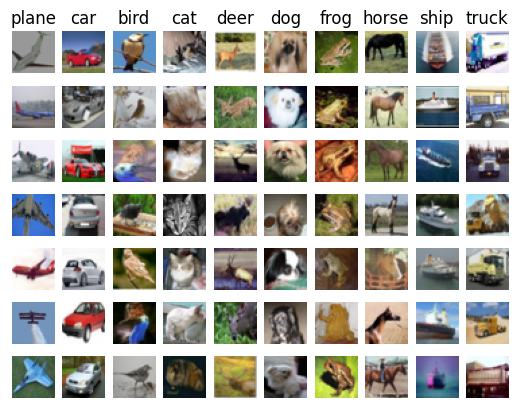

In [175]:
torch.manual_seed(42)

num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = torch.nonzero(y_train == y, as_tuple=True)[0]
    idxs = idxs[torch.randint(len(idxs), (samples_per_class, ))]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].permute(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Implement NearestNeighbor class

In [176]:
class KNearestNeighbor:
  def __init__(self, k = 1):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    num_test = len(X)

    # flatten every image tensor to vector size of 3 * 32 * 32
    test_flatten = X.flatten(1)
    train_flatten = self.X_train.flatten(1)

    test_sq = torch.sum(torch.square(test_flatten), 1)
    train_sq = torch.sum(torch.square(train_flatten), 1)

    dists = torch.sqrt(test_sq.reshape(-1, 1) + train_sq - 2 * torch.matmul(test_flatten, train_flatten.T))
    y_pred = torch.zeros(num_test, dtype=torch.int64)

    for i in range(num_test):
      # find idxs of top k lowest distances.
      k_idxs = torch.topk(dists[i], self.k, largest=False).indices
      # count amount of each class.
      classes_counter = torch.bincount(self.y_train[k_idxs])
      # choose the class that occurs most often.
      y_pred[i] = torch.argmax(classes_counter)

    return y_pred

## Cross-validation

In [179]:
def get_accuracy(model, X, y):
  y_pred = model.predict(X)
  return torch.sum(y_pred == y) / len(y)

5-fold cross-validation for k

In [210]:
NUM_FOLDS = 5
K_CHOICES = list(range(1, 150, 2))

X_train_folds = torch.tensor_split(X_train, NUM_FOLDS)
y_train_folds = torch.tensor_split(y_train, NUM_FOLDS)
k_to_accuracies = {}

for i, k in enumerate(K_CHOICES):
    fold_acc = 0
    for num_knn in range(0,NUM_FOLDS):
        X_val = X_train_folds[num_knn]
        y_val = y_train_folds[num_knn]

        X_train_curr = torch.cat(X_train_folds[:num_knn] + X_train_folds[num_knn + 1:])
        y_train_curr = torch.cat(y_train_folds[:num_knn] + y_train_folds[num_knn + 1:])

        classifier = KNearestNeighbor(k=k)
        classifier.fit(X_train_curr, y_train_curr)

        accuracy = get_accuracy(classifier, X_val, y_val)
        fold_acc += accuracy

    fold_acc /= NUM_FOLDS
    k_to_accuracies[k] = fold_acc

    if i % 5 == 0:
      print('i = {0} | k = {1}, average = {2:.3f}'.format(i, k, fold_acc))

best_k = max(k_to_accuracies, key=k_to_accuracies.get)
print('Best k = {0}, accuracy = {1:.3f}'.format(best_k, k_to_accuracies[best_k]))

i = 0 | k = 1, average = 0.257
i = 5 | k = 11, average = 0.267
i = 10 | k = 21, average = 0.267
i = 15 | k = 31, average = 0.271
i = 20 | k = 41, average = 0.268
i = 25 | k = 51, average = 0.272
i = 30 | k = 61, average = 0.266
i = 35 | k = 71, average = 0.263
i = 40 | k = 81, average = 0.258
i = 45 | k = 91, average = 0.257
i = 50 | k = 101, average = 0.256
i = 55 | k = 111, average = 0.257
i = 60 | k = 121, average = 0.255
i = 65 | k = 131, average = 0.252
i = 70 | k = 141, average = 0.254
Best k = 35, accuracy = 0.274


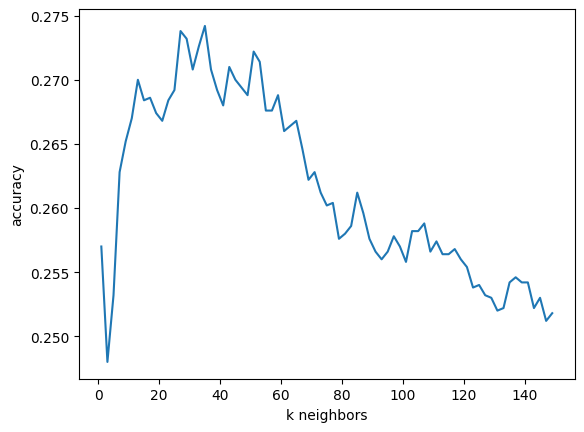

In [211]:
lists = sorted(k_to_accuracies.items())
x, y = zip(*lists)
plt.xlabel("k neighbors")
plt.ylabel("accuracy")
plt.plot(x, y)
plt.show()

## Get accuracy on test data

In [216]:
model = KNearestNeighbor(k=best_k)
model.fit(X_train, y_train)
accuracy = get_accuracy(model, X_test, y_test)
print ("Accuracy {:.3f}".format(accuracy))

Accuracy 0.290
